# Introduction

### Goal

Our goal was to develop a food recognition model, which would allow us to identify a food type based on an image.

### Approach


We opted by implementing Convolutional Neural Networks (CNN), for it's relative ease of implementation, accuracy and because we think it is the one that best suited our problem.

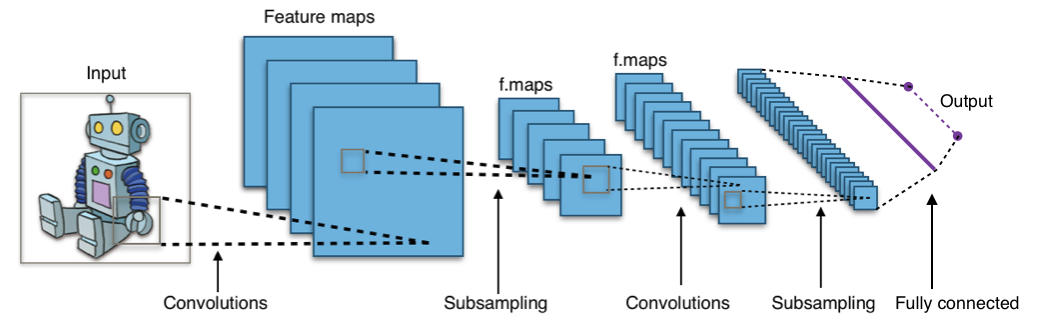

We followed several ideas we found online, but tweaking them to our needs and available resources.

### First idea

We first opted to base our approach on the [work developed by Patrick Rodriguez](https://github.com/stratospark/food-101-keras) as it seemed to be a very complete development of our idea.

However, we soon realized several problems with this approach:

1. **Old libraries**: The original notebook was built using old versions of tensorflow and keras, making it dificult to run the notebook on our machines.
2. **Large RAM usage**: The original author also opted to load the entire dataset into memory, which required more than 80GB of RAM
3. **Large dataset:** As discussed with the professor, we realized that using a very large dataset (with 100 classes and 1000 images for each class), would make training and building the model very difficult, given the resources we have available.



### Data Description

To implement this algorithm we used one of the popular pick when it comes to food recognition, which is [Food-101](https://www.kaggle.com/dansbecker/food-101), which is divided in four major folders: 
 * Images (contais all the +94000 images)
 * Meta (Declaration of 101 classes and labels)
 * Train (Contains the classes divided for training)
 * Test (Contains the classes divided for testing)  
 
 
 Since training this would be very costly computer and time wise, and we were bounded by restraints on both of those, we chose to create our subset called **Food-5** and **Food-10**, which had five and ten classes respectively.

The majority of training was made for the dataset Food-5, but we realized that the dataset had some similar classes and sometimes the algorithm couldnt identify the food with a good accuracy, so we ran a few more test for dataset Food-10, which took us about 12 hours.

# Prepare environment 

### Install dependencies 

In [1]:
!pip install tensorflow==2.1.0

In [2]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


### Load Google Drive 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [4]:

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import collections
import json

# from predict import predict, predict_remote_image

print('imports success')

imports success


In [5]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


# Load dataset

### Download dataset

The dataset we built from the original one can be downloaded [here](https://drive.google.com/drive/folders/1N792IKeqhaJFQCuABkFMv_idpQEFS_12?usp=sharing)

### Split images between *train* and *test* 

In [0]:
print('Spliting data between test and train dirs')

# Only split files if haven't already
if not os.path.isdir('/content/drive/My Drive/Colab Notebooks/food-5/test') and not os.path.isdir('/content/drive/My Drive/Colab Notebooks/food-5/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = collections.defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('/content/drive/My Drive/Colab Notebooks/food-5/meta/train.txt')
    test_dir_files = generate_dir_file_map('/content/drive/My Drive/Colab Notebooks/food-5/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('/content/drive/My Drive/Colab Notebooks/food-5/images', '/content/drive/My Drive/Colab Notebooks/food-5/test', ignore=ignore_train)
    copytree('/content/drive/My Drive/Colab Notebooks/food-5/images', '/content/drive/My Drive/Colab Notebooks/food-5/train', ignore=ignore_test)

else:
    print('Train/Test files already copied into separate folders.')

print('done')

Spliting data between test and train dirs
Train/Test files already copied into separate folders.
done


### Map class numbers to labels

In [0]:
class_to_ix = {}
ix_to_class = {}
with open('/content/drive/My Drive/Colab Notebooks/food-5/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

### Visualize images from dataset

This allows us to view random images from the dataset

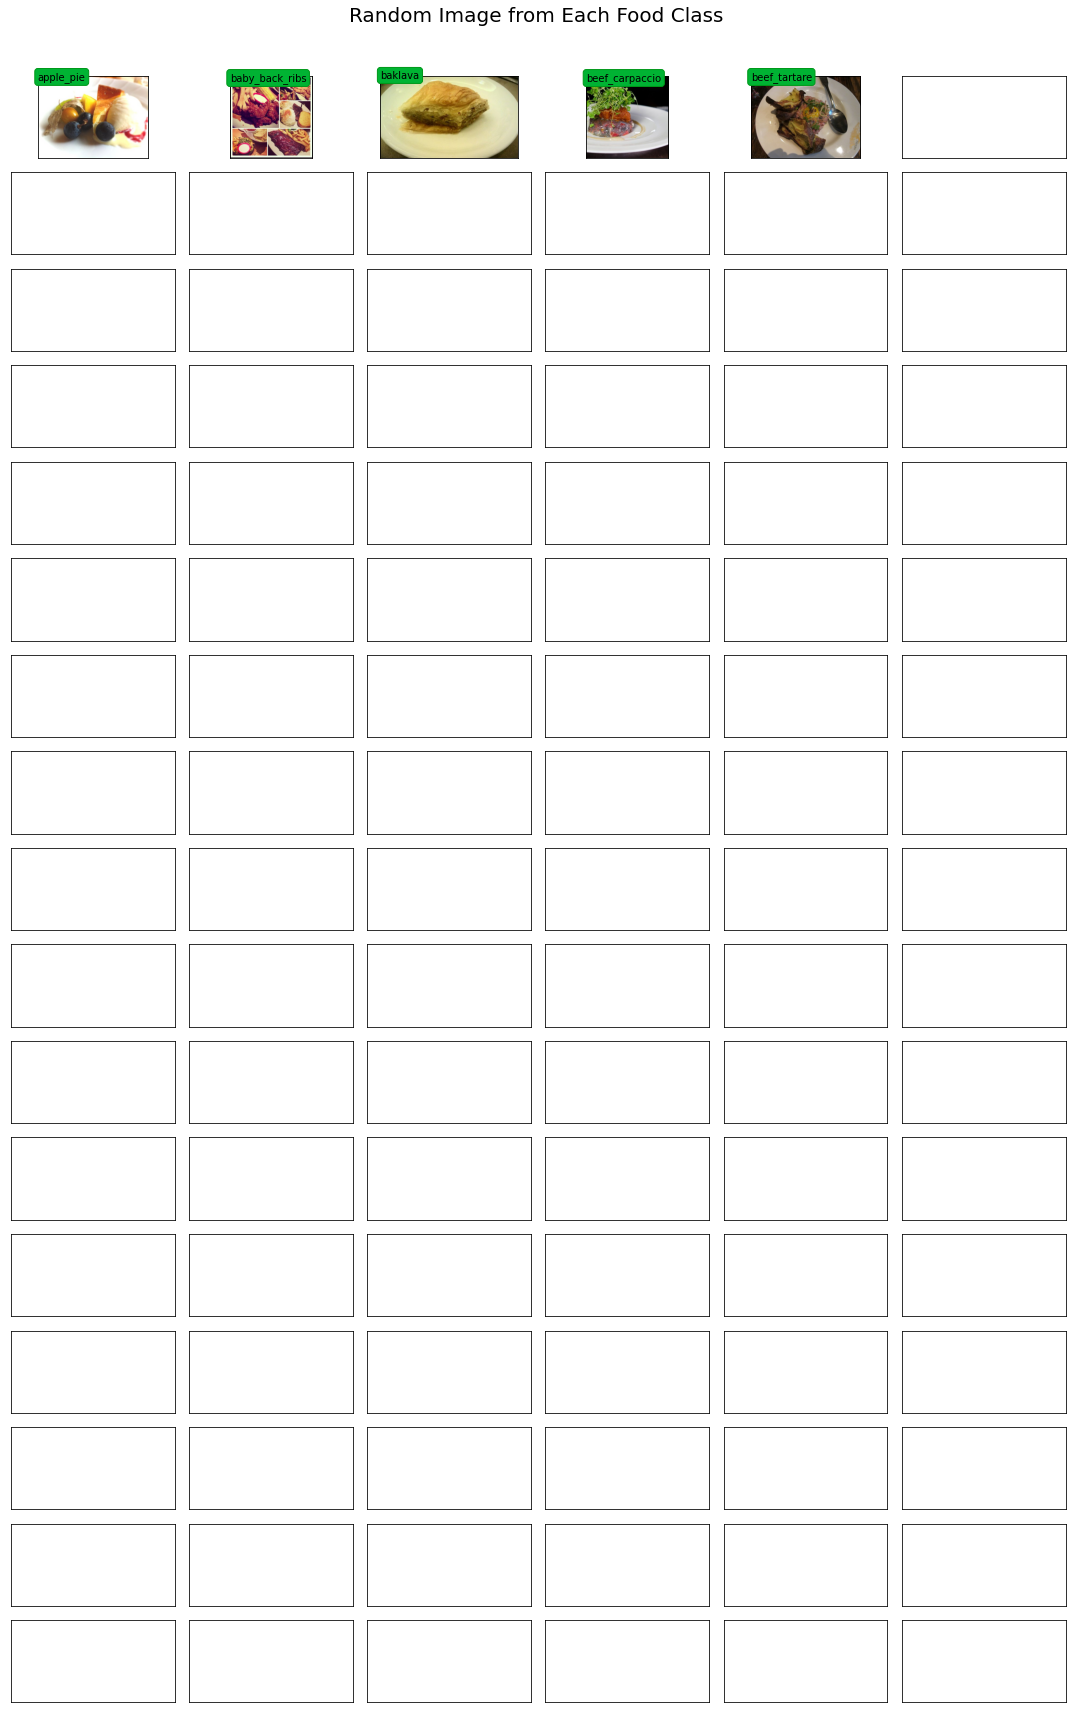

In [0]:
# View random images from dataset

root_dir = '/content/drive/My Drive/Colab Notebooks/food-5/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Import dataset into generator

We loaded the images for training using a ImageDataGenerator, which also allowed us to make the necessary preprocessing to the images.

In this case, we start by **rescaling** them by 1/255, reshape them into 244X244 pixels (by 3-RGB).

This method also allowed us to save on memory allocation, as addressed in the Introduction, as it allowed us to load the images in batches.

In [7]:
base_dir = '/content/drive/My Drive/Colab Notebooks/food-5/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# each class will be inside here

# all images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# flow train images in batches of 20 using train_datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='categorical', 
                                                    shuffle=False,
                                                    target_size=(244, 244))

# flow validation images in batches of 20 using train_datagen 
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=128,
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  target_size=(244, 244))


Found 3754 images belonging to 5 classes.
Found 1249 images belonging to 5 classes.


# Training - 1st attempt

The following was our first attempt. 

After trying to follow different, more complex approaches, we decided to start with a simpler model, built from scratch.

We have reached an accuracy of more than 0.99. However, following the metrics we established above (under **Evaluation**), we only got a score of arround 65%.

### Build model

We built this model on top of a **Sequential** model, with **3 conventional blocks**, followed by a **flatten layer**, the **hidden dense layer**, and the ouput layer. 

In [0]:
# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(244, 244, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
class_num = 5
model.add(Dense(units=class_num, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# evaluate the model
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# model summary
print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 25)      1900      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 244, 244, 25)      15650     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 25)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 50)        31300     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 50)        62550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 50)        2

### Train

In [0]:
# checkpointer = ModelCheckpoint(filepath='model.2.hdf5', verbose=1, save_best_only=True)

# fit on data for 30 epochs
#model.fit(train_generator, epochs=30, steps_per_epoch=60, batch_size=64, validation_data=test_generator)
history = model.fit(train_generator, epochs=30, validation_data=test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 10 steps
Epoch 1/30
30/30 [==============================] - 2040s 68s/step - loss: 1.6499 - accuracy: 0.0927 - val_loss: 1.6058 - val_accuracy: 0.2002
Epoch 2/30
30/30 [==============================] - 1510s 50s/step - loss: 1.6152 - accuracy: 0.1857 - val_loss: 1.6068 - val_accuracy: 0.2002
Epoch 3/30
30/30 [==============================] - 1504s 50s/step - loss: 1.6118 - accuracy: 0.2040 - val_loss: 1.6038 - val_accuracy: 0.2106
Epoch 4/30
30/30 [==============================] - 1500s 50s/step - loss: 1.6036 - accuracy: 0.2136 - val_loss: 1.6009 - val_accuracy: 0.2394
Epoch 5/30
30/30 [==============================] - 1503s 50s/step - loss: 1.5974 - accuracy: 0.1665 - val_loss: 1.5955 - val_accuracy: 0.2378
Epoch 6/30
30/30 [==============================] - 1505s 50s/step - loss: 1.6049 - accuracy: 0.2171 - val_loss: 1.6292 - val_accuracy: 0.2298
Epoch 7/30
30/30 [==============================] 

On this first attempt, training took a long time, about 4/5 hours... 

As mentioned before, we managed to have a good accuracy, but a bad validation accuracy, which severely influenced our tests results.

**RESULTS**: Accuracy of 64.8% (as measured in evaluation); 4/5 hours to train

# Trainning - 2nd attempt with transfer learning from MobileNetV2

For this second attempt, we tried to implement transfer learning. 

After research, we decided to try with a relatively simple model, MobileNetV2, as our dataset is also small.

### Reload *train* and *test* generators

For this implementation, we had to reload the images into the generator, as we followed a different classification mode.

In [0]:
base_dir = '/content/drive/My Drive/Colab Notebooks/food-5/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# each class will be inside here

# all images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# flow train images in batches of 20 using train_datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='sparse', # change to 'categorical for 1st attempt
                                                    shuffle=False,
                                                    target_size=(244, 244))

# flow validation images in batches of 20 using train_datagen 
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=128,
                                                  class_mode='sparse', # change to 'categorical for 1st attempt
                                                  shuffle=False,
                                                  target_size=(244, 244))

### Build model

We started build the model on top of MobileNetV2, adding just a **Flatten** and a **Dense** layer.

As mentioned before, we followed a different classification mode: **sparse**.

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
import numpy as np
import argparse

shape = (244, 244, 3)
num_classes = 5

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=shape, include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 409605    
Total params: 2,667,589
Trainable params: 409,605
Non-trainable params: 2,257,984
_________________________________________________________________


### Train

In [0]:
# model.fit(train_generator, validation_data=test_generator,
#                           epochs=25, 
#                           steps_per_epoch=train_generator.samples//32,
#                           validation_steps=test_generator.samples//32)

history = model.fit(train_generator, epochs=30, validation_data=test_generator)

**RESULTS:** We reached an accuracy of arround 30%, but the training was the fastest of all the approaches, taking only about 30 minutes

# Training - 3rd attempt from InceptionV3

After succeding with tranfer learning with a simpler model, we tried to move to a more comlex one, having chosen **InceptionV3**, because of the good documentation we found online with regards to similar problems.

This was also the pretrained model used by the author on the notebook we consulted.

We have also tried using **VGG16**, but **InceptionV3** proved to have better accuracy.

With more time, we would like to try loading different base models, and compare performance and results between all of them.

### Import pretrained model

Import the model, excluding the last layer.

In [8]:
from tensorflow.keras.applications import InceptionV3

# import pretrained model
pretrained_model = InceptionV3(weights = 'imagenet',include_top = False)

pretrained_model.summary()


87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

### Extract features 

With this model, as oppose to the 2nd approach, we loaded the features from our training and testing set using the pretrained model, previously imported.

This step took almost 1 hour.

In [9]:
# extract train and val features
print('Extracting train features...', end='')
pretrained_features_train = pretrained_model.predict(train_generator)
print('Done')
print('Extracting test features...', end='')
pretrained_features_test = pretrained_model.predict(test_generator)
print('Done')

Extracting train features...Done
Extracting test features...Done


Extract the labels

In [0]:
from tensorflow.keras.utils import to_categorical

# OHE target column
train_target = to_categorical(train_generator.labels)
test_target = to_categorical(test_generator.labels)


### Build model

On top of the pretrained model, we built a simple **Sequential** model, with a **Flatten** and a **Dense** layer.

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(6, 6, 2048)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

class_num = 5 
model.add(Dense(class_num, activation='softmax'))

# compile the model
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               7372900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 7,373,805
Trainable params: 7,373,605
Non-trainable params: 200
_________________________________________________________________


### Train

For the training, we fed the features (previously processed by the pretrained model) into the new model.

This was really fast, because our model was very simple, and the pretrained model had already done most of the processing.

In [12]:
# train model using features generated from VGG16 model
history = model.fit(pretrained_features_train, train_target, epochs=50, batch_size=128, validation_data=(pretrained_features_test, test_target))

Train on 3754 samples, validate on 1249 samples
Epoch 1/50
3754/3754 [==============================] - 5s 1ms/sample - loss: 0.9394 - accuracy: 0.6428 - val_loss: 0.5930 - val_accuracy: 0.8078
Epoch 2/50
3754/3754 [==============================] - 4s 1ms/sample - loss: 0.5848 - accuracy: 0.8087 - val_loss: 0.5272 - val_accuracy: 0.8207
Epoch 3/50
3754/3754 [==============================] - 4s 1ms/sample - loss: 0.4518 - accuracy: 0.8426 - val_loss: 0.4411 - val_accuracy: 0.8375
Epoch 4/50
3754/3754 [==============================] - 4s 1ms/sample - loss: 0.3542 - accuracy: 0.8969 - val_loss: 0.4443 - val_accuracy: 0.8415
Epoch 5/50
3754/3754 [==============================] - 4s 1ms/sample - loss: 0.2795 - accuracy: 0.9243 - val_loss: 0.4538 - val_accuracy: 0.8391
Epoch 6/50
3754/3754 [==============================] - 4s 1ms/sample - loss: 0.2178 - accuracy: 0.9435 - val_loss: 0.4347 - val_accuracy: 0.8367
Epoch 7/50
3754/3754 [==============================] - 4s 1ms/sample - loss

### Evaluate the model

In [0]:
#Evaluate the model on the test data
score  = model.evaluate(pretrained_features_test, test_target)

#Accuracy on test data
print('Accuracy on the Test Images: ', score[1])

1249/1249 [==============================] - 1s 583us/sample - loss: 0.6093 - accuracy: 0.8471
Accuracy on the Test Images:  0.84707767


We got a very good accuracy, as the results (shown ahead) will confirm.

**RESULTS**: Accuracy of 80%, taking about 1 hour.

# Save model

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model3.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# serialize ix_to_class
with open("ix_to_class.json", "w") as json_file:
  json_file.write(json.dumps(ix_to_class))

# Load model

In [0]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/Colab Notebooks/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/model3.h5")
print("Loaded model from disk")
 
model = loaded_model;

model.summary()

Loaded model from disk
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 2,509,805
Trainable params: 2,509,605
Non-trainable params: 200
_________________________________________________________________


In [0]:
# read ix_to_class
with open("/content/drive/My Drive/Colab Notebooks/ix_to_class.json") as json_file:
  loaded_ix_to_class = json_file.read()

ix_to_class = json.loads(loaded_ix_to_class)

print(ix_to_class)

{'0': 'apple_pie', '1': 'baby_back_ribs', '2': 'baklava', '3': 'beef_carpaccio', '4': 'beef_tartare'}


# Evaluation

### Plot history

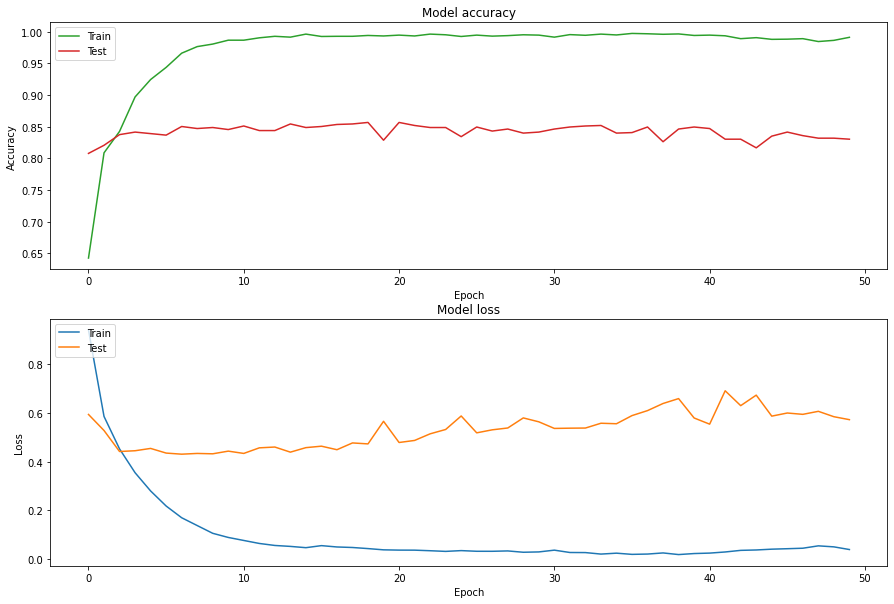

In [13]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

### Accuracy Score

In [0]:
base_dir = '/content/drive/My Drive/Colab Notebooks/food-5/'

test_dir = os.path.join(base_dir, 'test')

# each class will be inside here

# all images will be rescaled by 1./255
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# flow validation images in batches of 20 using train_datagen 
val_generator = val_datagen.flow_from_directory(test_dir,
                                                batch_size=128,
                                                class_mode='categorical',
                                                shuffle=False,
                                                target_size=(244, 244))

Found 1249 images belonging to 5 classes.


In [0]:
from sklearn.metrics import accuracy_score

x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

For the **3rd attemp** (with transfer learning), we need to apply another layer of processing.

First, we extract the features using the pretrained model, and then we predict with our model.

In [0]:
from sklearn.metrics import accuracy_score

x_test, y_test = val_generator.next()
features = pretrained_model.predict(x_test)
y_pred_conf = model.predict(features) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

ValueError: ignored

### Check 5 random images

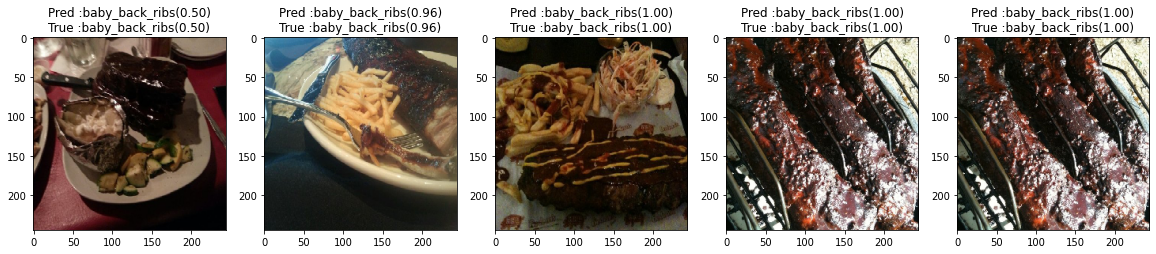

In [0]:
ind = np.random.randint(1,len(x_test),5)
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (ix_to_class[str(y_pred[j])],np.max(y_pred_conf[j]),
                           ix_to_class[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))



### Confusion matrix

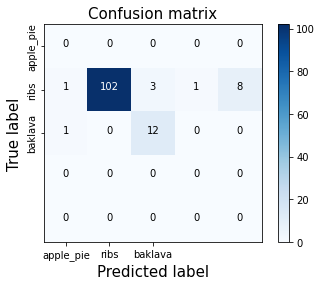

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','ribs','baklava', 'beef_carpaccio', 'beef_tartare']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

### Receiver Operating Characterisics (ROC) Curve

In [0]:
from sklearn.metrics import roc_curve, auc

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_conf[:, i]) # roc_curve function apply to binary class only
    roc_auc[i] = auc(fpr[i], tpr[i])  # using the trapezoidal rule to get area under curve


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


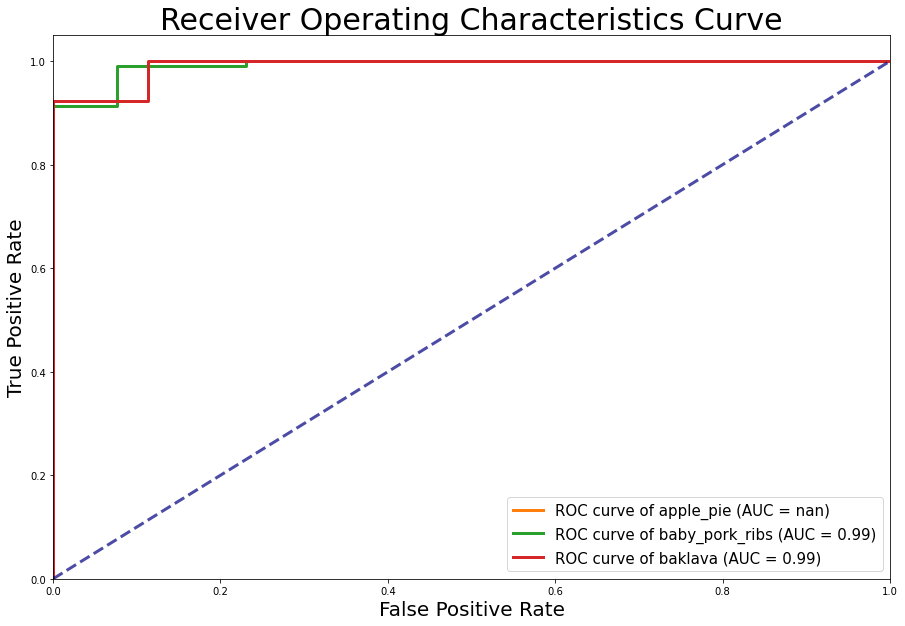

In [0]:
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(15,10))
    plt.plot(fpr[0], tpr[0], color='C1', lw=3, label='ROC curve of apple_pie (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='C2', lw=3, label='ROC curve of baby_pork_ribs (AUC = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='C3', lw=3, label='ROC curve of baklava (AUC = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)

### Inspect the predictions with wrong labels

In [0]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (ix_to_class[str(pred_errors[error])],y_pred_errors_prob[error],
                                       ix_to_class[str(obs_errors[error])],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

In [0]:
show_wrongest_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.

### Accuracy by class

Text(0.5, 1.0, 'Accuracy by Class histogram')

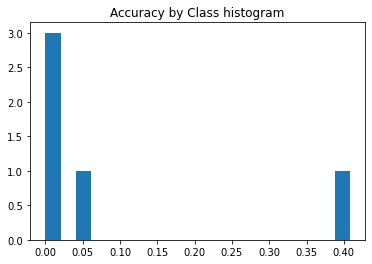

In [0]:
corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)
for (pred, actual_v) in zip(y_pred, y_test):
    actual = np.where(actual_v == 1)[0][0]
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

class_accuracies = {}
for ix in range(5):
    class_accuracies[ix] = corrects[ix]/250

plt.hist(list(class_accuracies.values()), bins=20)
plt.title('Accuracy by Class histogram')

In [0]:
sorted_class_accuracies = sorted(class_accuracies.items(), key=lambda x: -x[1])
[(ix_to_class[str(c[0])], c[1]) for c in sorted_class_accuracies]

[('baby_back_ribs', 0.408),
 ('baklava', 0.048),
 ('apple_pie', 0.0),
 ('beef_carpaccio', 0.0),
 ('beef_tartare', 0.0)]

# Predicions

In [0]:
### Predict funcs

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from skimage.transform import resize

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import collections

import urllib.request

def center_crop(x, center_crop_size, **kwargs):
    centerw, centerh = x.shape[0]//2, x.shape[1]//2
    halfw, halfh = center_crop_size[0]//2, center_crop_size[1]//2
    return x[centerw-halfw:centerw+halfw+1,centerh-halfh:centerh+halfh+1, :]

def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    print('Img shape:', np.array(img).shape)
    flipped_X = np.fliplr(img)
    size = 150
    crops = [
        img[:size,:size, :], # Upper Left
        img[:size, img.shape[1]-size:, :], # Upper Right
        img[img.shape[0]-size:, :size, :], # Lower Left
        img[img.shape[0]-size:, img.shape[1]-size:, :], # Lower Right
        center_crop(img, (size, size)),

        flipped_X[:size,:size, :],
        flipped_X[:size, flipped_X.shape[1]-size:, :],
        flipped_X[flipped_X.shape[0]-size:, :size, :],
        flipped_X[flipped_X.shape[0]-size:, flipped_X.shape[1]-size:, :],
        center_crop(flipped_X, (size, size))
    ]
    if preprocess:
        crops = [preprocess_input(x.astype('float32')) for x in crops]

    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])

    print('Crop. shape:', np.array(crops).shape)
    y_pred = model.predict(np.array(crops))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

def predict(img, model, top_n=5, debug=False):
    resized_img = np.resize(img, (1, 244, 244, 3))
    y_pred = model.predict(np.array(resized_img))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
    return preds, top_n_preds

def predict_remote_image(url, model, ix_to_class, debug=False):
    with urllib.request.urlopen(url) as f:
        pic = plt.imread(f, format='jpg')
        preds = predict(np.array(pic), model, debug=debug)[0]
        best_pred = collections.Counter(preds).most_common(1)[0][0]
        print(ix_to_class[best_pred])
        # plt.imshow(pic)

def predict_image(path, model, ix_to_class, debug=False):
    pic = img.imread(path)
    preds = predict(np.array(pic), model, 0, debug=debug)[0]
    best_pred = collections.Counter(preds).most_common(1)[0][0]
    print(ix_to_class[best_pred])


The following functions need to be run only when using the **3rd model**, because of transfer learning.

In [0]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from skimage.transform import resize

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import collections

import urllib.request

def predict(img, model, ix_to_class=None):
  resized_img = np.resize(img, (1, 244, 244, 3))
  feats = pretrained_model.predict(np.array(resized_img))
  preds = model.predict(feats)
  if (ix_to_class != None):
    for pred in preds:
      print(pred)
  preds = np.argmax(preds, axis=1)
  best_pred = collections.Counter(preds).most_common(1)[0][0]
  print(ix_to_class[str(best_pred)])
  return preds

def predict_remote_image(url, model, ix_to_class=None):
    with urllib.request.urlopen(url) as f:
        pic = plt.imread(f, format='jpg')
        #plt.imshow(pic)
        preds = predict(np.array(pic), model, ix_to_class=ix_to_class)
        return preds

In [0]:
# baklava
predict_remote_image(url='https://www.fifteenspatulas.com/wp-content/uploads/2012/03/Baklava-Fifteen-Spatulas-11.jpg', model=model, ix_to_class=ix_to_class)
# apple pie
predict_remote_image(url='https://images-gmi-pmc.edge-generalmills.com/75593ed5-420b-4782-8eae-56bdfbc2586b.jpg', model=model, ix_to_class=ix_to_class)
# beef tartare
predict_remote_image(url='https://mission-food.com/wp-content/uploads/2020/02/Steak-Tartare-16.jpg', model=model, ix_to_class=ix_to_class)


[0.0000000e+00 1.3306978e-34 1.0000000e+00 1.9543608e-11 8.4210285e-33]
baklava
[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 6.4783588e-34]
baby_back_ribs
[0.0000000e+00 1.0000000e+00 1.0167557e-30 4.1130151e-33 6.0166949e-27]
baby_back_ribs


array([1])

In [0]:
predict_remote_image(url='https://images-gmi-pmc.edge-generalmills.com/75593ed5-420b-4782-8eae-56bdfbc2586b.jpg', model=model, ix_to_class=ix_to_class)

[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 6.4783588e-34]
baby_back_ribs


array([1])

# Conclusions

In conclusion, the results we got were overall very satisfying, since this problem is very complex and demands a lot of computing power and resources.  
We had the best accuracy with the last model: **InceptionV3**, which is based on an already existing model but retrained for our purpose.  
Our dataset was also very small and it clearly showed in the data not being as accurate as it could. Bigger datasets would have improved our accuracy but as mentioned before, would be too expensive to train.  
In a future stage, we would like to continue working on this and training the model with the full dataset to get a more complex model, capable of understanding a lot of common dishes.